In [1]:
import bForStrain as bFS
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize


Create mesh and construct it, using the parameters specified in params.py. This file includes both meshing parameters and inversion parameters. For the mesh, it reads in two data files: velocity data and optionally creeping fault segments, alongside some mesh density and spacing parameters.

In [2]:
from params import gps_file

mesh=bFS.Mesh(gps_file)

Building mesh from coordinates and extent given in params.py


In [20]:
mesh.construct()


 Smooth triangulation...

 -----------------------------------------------------------------------
      |ITER.|          |MOVE(X)|          |DTRI(X)|          |T. ITER|  
 -----------------------------------------------------------------------
          4               2401               5366             0.086000
          8               1168               5334             0.045000
         12                179               5330             0.053000
         16                  7               5330             0.055000
         20                  0               5330             0.059000


The smoothing algorithm (Mesh2D) uses an area to length ratio as a score metric, normalized so the target value is 1. Each iteration attempts to improve this score. We can view the mesh quality by using mesh.plot() and specifying various arguments. This same method is later used to plot inversion results with additional inputs.

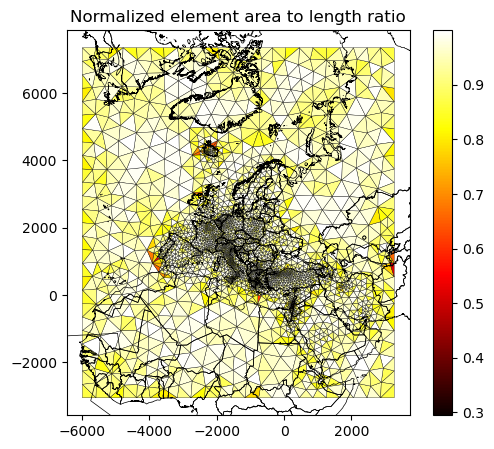

In [4]:
ax=mesh.plot(colormap='hot',edges=True,borders=True)
ax.set_title("Normalized element area to length ratio")
plt.show()

In [5]:
# remaps velocity data to mesh elements
mesh.assign_centroids()

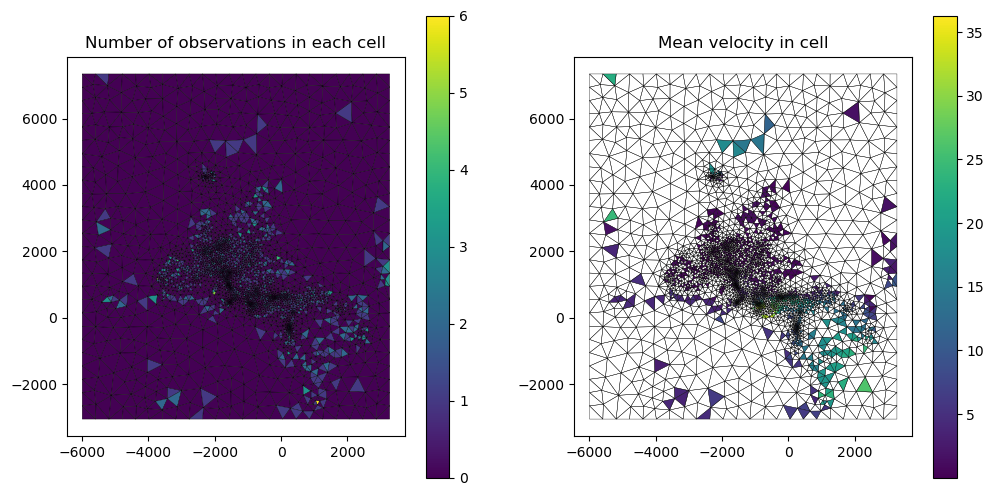

In [6]:
values=[mesh.num_data_tri,
        mesh.vel_centroids.mag()]

ax=mesh.plot(values,edges=True,lonlat=False,borders=False)
ax[0].set_title("Number of observations in each cell")
ax[1].set_title("Mean velocity in cell")
plt.show()

To view velocity vectors, we have a different plotting method which can also plot modeled velocities.

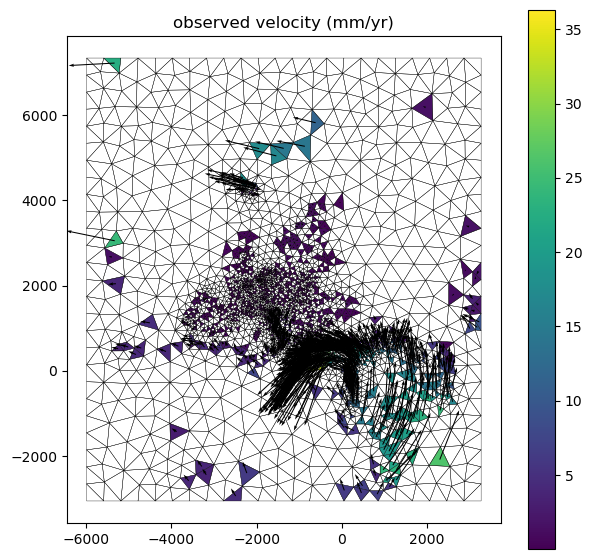

In [7]:
ax=mesh.plot_vels(plot_centroid=True)
ax[0].set_title("observed velocity (mm/yr)")
plt.show()

Generate inversion results by calling bFS.Inversion using the constructed mesh as an argument. This will read in the inversion parameters in params.py, primarily beta (weights on minimizing body forces), uncertainty flag (computes num realizations of inversion result with uncertainties), and twostep flag and parameters (performs a second inversion step minimizing strain rates below the threshold within the x and y bounds provided).

In [8]:
results = bFS.Inversion(mesh)


Computing Body Force Green's Functions
Performing inversion
Inversion time: 12.7 seconds
Chi-2 for beta = 40: 4.61
Performing inversion
Inversion time: 12.8 seconds
Chi-2 for beta = 45: 5.03
Performing inversion
Inversion time: 12.9 seconds
Chi-2 for beta = 50: 5.43


In [9]:
results.post_process()

Unwrapping results to 2D numpy arrays. Calculating dilitation and max shear.


Plotting the results.

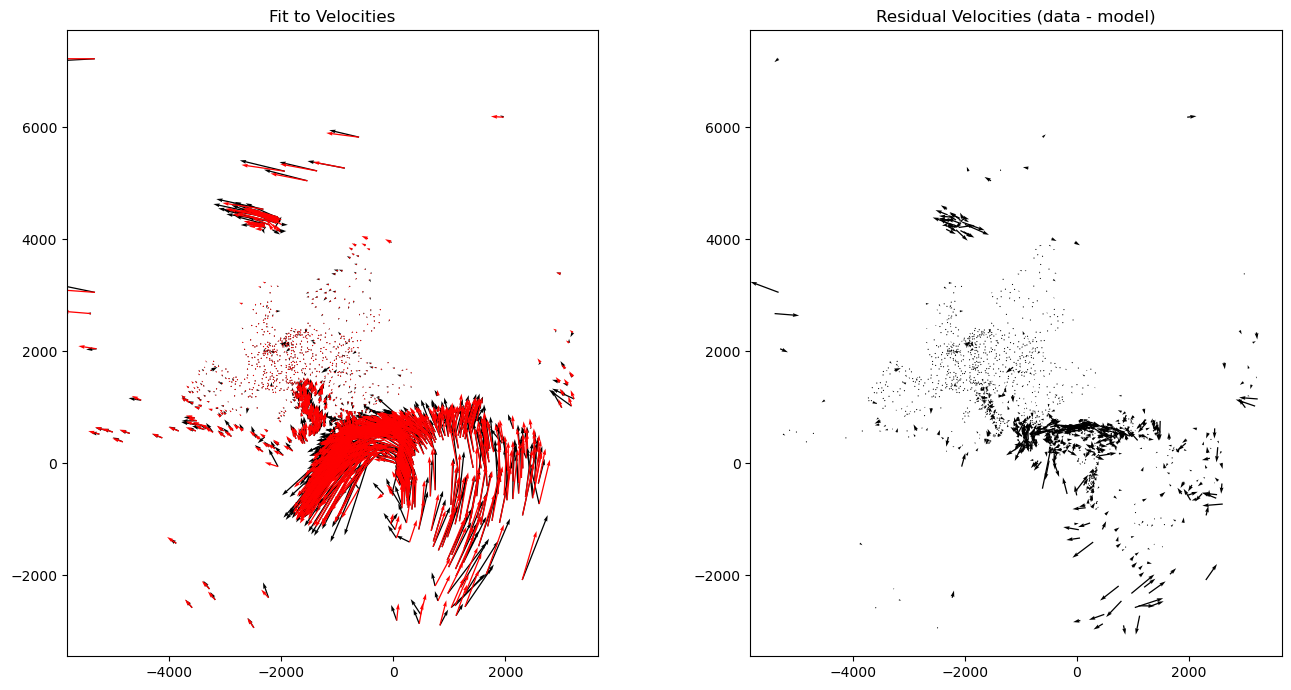

In [10]:
Ve_mean = results.Ve.mean(axis=0)
Vn_mean = results.Vn.mean(axis=0)

fig2 = mesh.plot_vels(Ve_mean,Vn_mean,residuals=True)

fig2[0].set_title('Fit to Velocities')
fig2[1].set_title('Residual Velocities (data - model)')

plt.tight_layout()
plt.show()

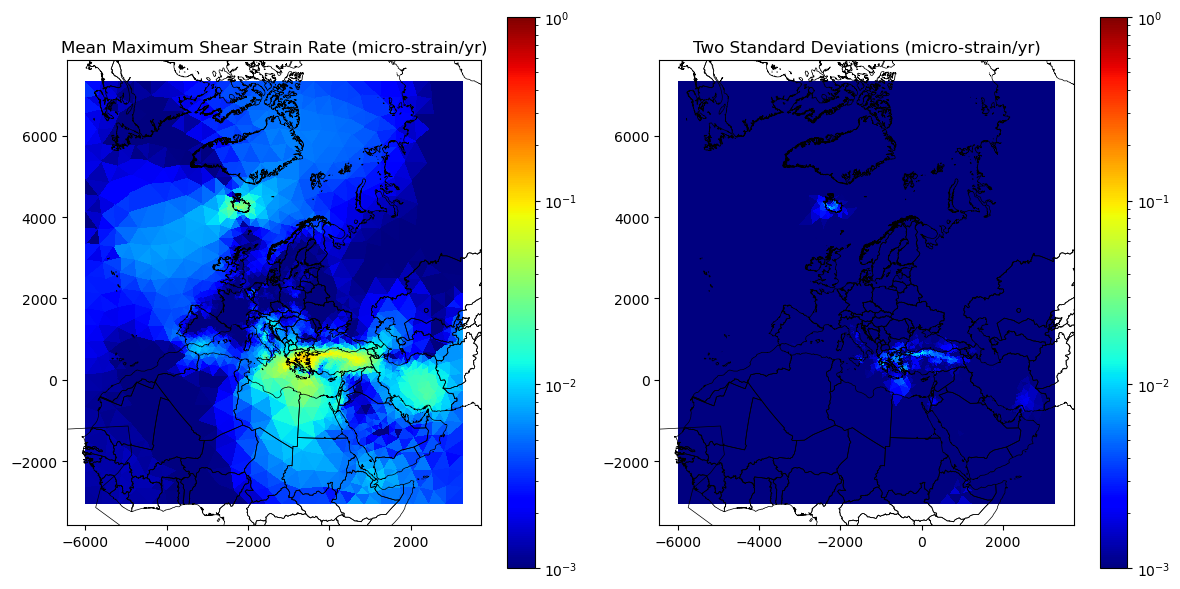

In [11]:
mean_maxshear = results.max_shear.mean(axis=0)
std_maxshear = results.max_shear.std(axis=0)
vals=[mean_maxshear,2*std_maxshear]

fig2 = mesh.plot(vals,colormap='jet',scale=LogNorm(vmin=0.001, vmax=1),borders = True)

fig2[0].set_title('Mean Maximum Shear Strain Rate (micro-strain/yr)')
fig2[1].set_title('Two Standard Deviations (micro-strain/yr)')

plt.tight_layout()
plt.show()

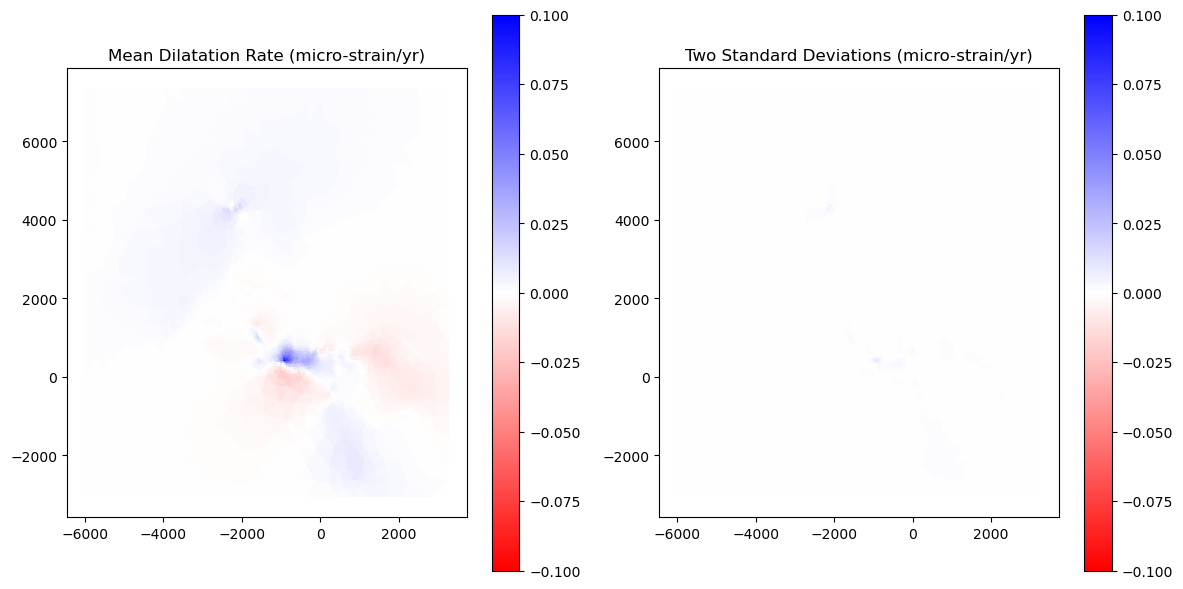

In [12]:
mean_dilatation = results.dilatation.mean(axis=0)
std_dilatation = results.dilatation.std(axis=0)

vals = [mean_dilatation,2*std_dilatation]

fig3 = mesh.plot(vals,colormap='bwr_r',scale=Normalize(vmin=-0.1, vmax=0.1))

fig3[0].set_title('Mean Dilatation Rate (micro-strain/yr)')
fig3[1].set_title('Two Standard Deviations (micro-strain/yr)')
plt.tight_layout()
plt.show()

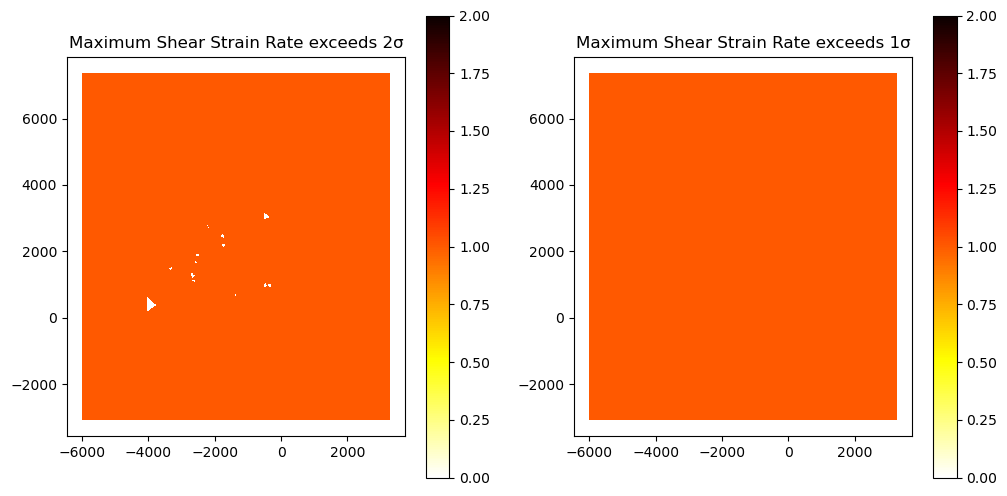

In [13]:
ind2sig = mean_maxshear > 2 * std_maxshear
ind1sig = mean_maxshear > 1 * std_maxshear

vals=[ind2sig,ind1sig]

fig4= mesh.plot(vals,colormap='hot_r',scale=Normalize(vmin=0, vmax=2))

fig4[0].set_title('Maximum Shear Strain Rate exceeds 2σ')
fig4[1].set_title('Maximum Shear Strain Rate exceeds 1σ')
plt.show()

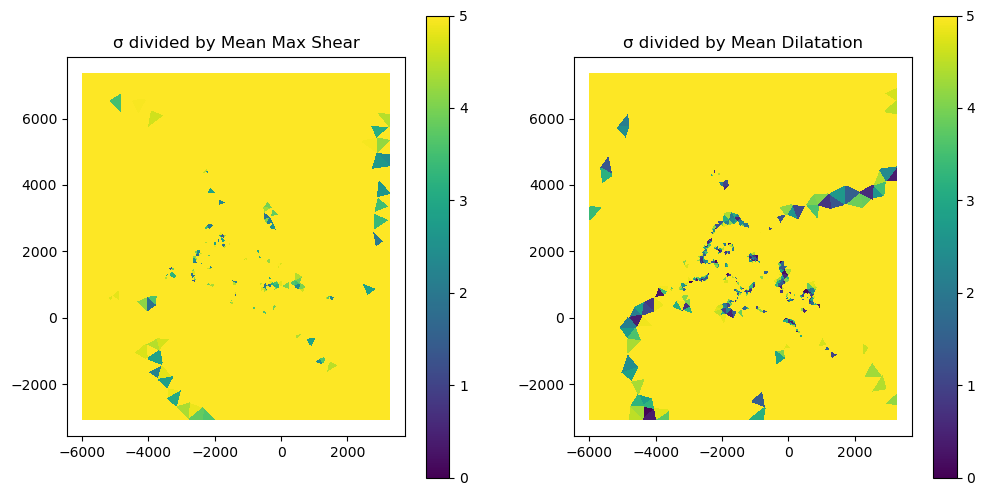

In [14]:
shear_rat = abs(mean_maxshear)/std_maxshear
dil_rat = abs(mean_dilatation)/std_dilatation

vals = [shear_rat, dil_rat]

fig5 = mesh.plot(vals,colormap='viridis',scale=Normalize(vmin=0, vmax=5))

fig5[0].set_title('σ divided by Mean Max Shear')
fig5[1].set_title('σ divided by Mean Dilatation')
plt.show()


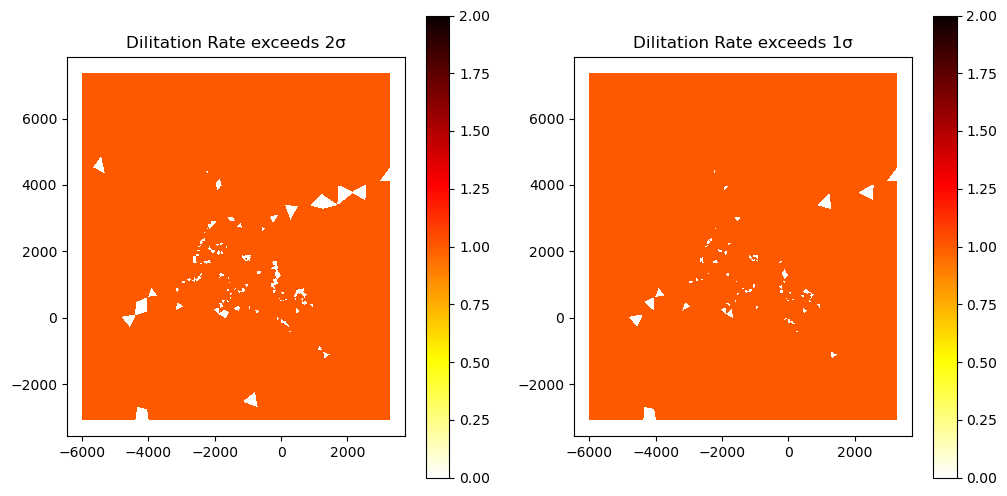

In [15]:

ind2sig = abs(mean_dilatation) > 2 * std_dilatation
ind1sig = abs(mean_dilatation) > 1 * std_dilatation

vals = [ind2sig, ind1sig]

fig6 = mesh.plot(vals,colormap='hot_r',scale=Normalize(vmin=0, vmax=2))

fig6[0].set_title('Dilitation Rate exceeds 2σ')
fig6[1].set_title('Dilitation Rate exceeds 1σ')
plt.show()

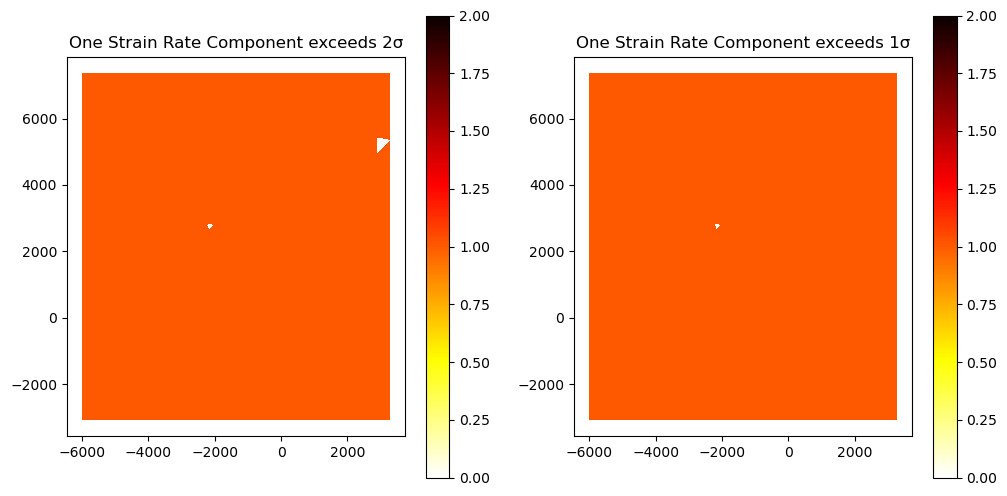

In [16]:

Exx_mean = results.Exx.mean(axis=0)
Exy_mean = results.Exy.mean(axis=0)
Eyy_mean = results.Eyy.mean(axis=0)

Exx_std = results.Exx.std(axis=0)
Exy_std = results.Exy.std(axis=0)
Eyy_std = results.Eyy.std(axis=0)

ind2sig = (abs(Exx_mean) > 2 * Exx_std) | (abs(Exy_mean) > 2 * Exy_std) | (abs(Eyy_mean) > 2 * Eyy_std)
ind1sig = (abs(Exx_mean) > 1 * Exx_std) | (abs(Exy_mean) > 1 * Exy_std) | (abs(Eyy_mean) > 1 * Eyy_std)

vals = [ind2sig, ind1sig]

fig7 = mesh.plot(vals,colormap='hot_r',scale=Normalize(vmin=0, vmax=2))

fig7[0].set_title('One Strain Rate Component exceeds 2σ')
fig7[1].set_title('One Strain Rate Component exceeds 1σ')
plt.show()

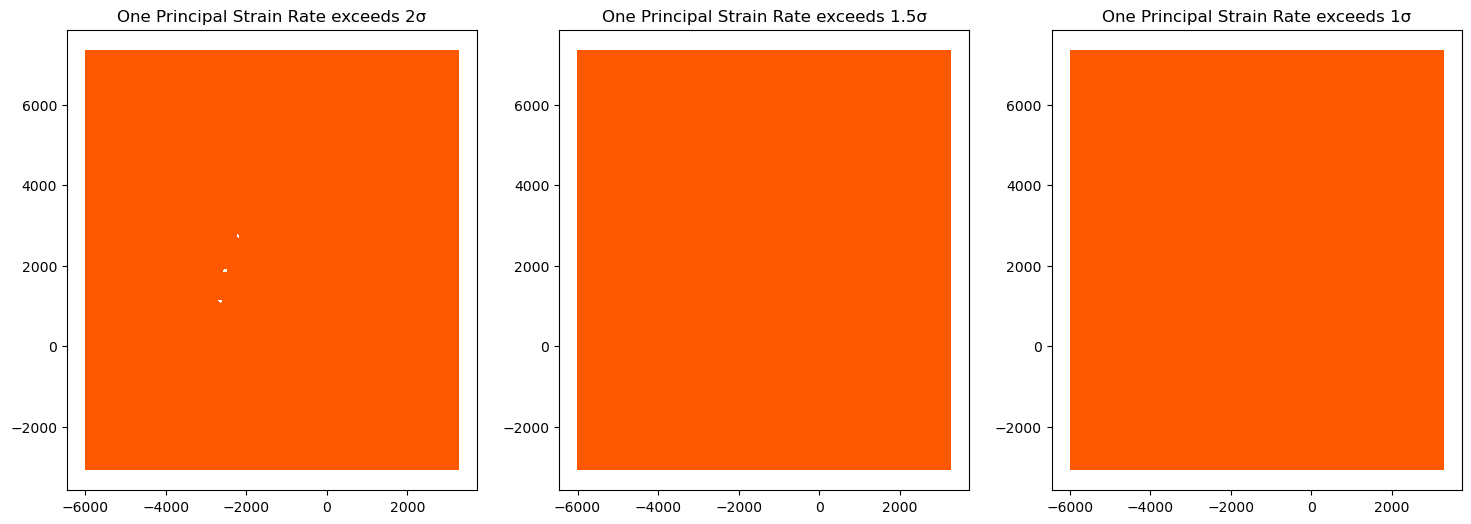

In [17]:
results.compute_Eeig()

mean_minvals = results.minvals.mean(axis = 0)
std_minvals  = results.minvals.std(axis = 0)

mean_maxvals = results.maxvals.mean(axis = 0)
std_maxvals  = results.maxvals.std(axis = 0)

ind1 = (abs(mean_minvals) > 1.0 * std_minvals) | (abs(mean_maxvals) > 1.0 * std_maxvals)
ind2 = (abs(mean_minvals) > 1.5 * std_minvals) | (abs(mean_maxvals) > 1.5 * std_maxvals)
ind3 = (abs(mean_minvals) > 2.0 * std_minvals) | (abs(mean_maxvals) > 2.0 * std_maxvals)

vals = [ind3,ind2,ind1]

fig8 = mesh.plot(vals,colormap='hot_r',cbar=False,scale=Normalize(vmin=0, vmax=2))

fig8[0].set_title('One Principal Strain Rate exceeds 2σ')
fig8[1].set_title('One Principal Strain Rate exceeds 1.5σ')
fig8[2].set_title('One Principal Strain Rate exceeds 1σ')
plt.show()

In [ ]:
pygmt.